<a href="https://colab.research.google.com/github/rajtum/Machine-Learning-Makeshift-Portfolio/blob/master/Sections/III%20Decision%20Tree%20Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization

### A. Imports

In [10]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# III. Imports
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# IV. Imports
from mpl_toolkits import mplot3d

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
import plotly.graph_objects as go
import plotly.express as px
import time

# V. Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#VI. Imports
from xgboost import XGBRegressor

#Helpful imports
import sys
#Allows arrays to fully print in the console without truncation
np.set_printoptions(threshold=sys.maxsize)

#Method used to save .csv files
def login_Drive():
  """
  First step to saving .csv produced is connecting to your drive. Calling this function will ask you
  to login into an gmail account and it will ask you to give permission to Google File Stream to 
  create, delete, view, and do anything on your drive when it is mounted. Since Google File Stream is
  a Google product and these permissions are only granted for a short while, it was determined to be
  a safe method to export DataFrames. Make sure to the read the full permissions demanded by Google
  File Stream before continuing.

  login_Drive()
  >>> Go to this URL in a browser: https://accounts.google.com/o/oauth2/....
  >>>
  >>> Enter your authorization code:
  >>> [Input Box]
  When successful, will return
  >>> Mounted at drive
  """
  from google.colab import drive
  drive.mount('drive')
def save_file(output_arg, file_name_arg, save_index = False):
  """
  Adds underscores to the string file_name, which then allows the file to be copied to the drive.
  The .csv file produced will not have indices and will be saved in the general My Drive area. Pasting
  the following returned string without the outside quotation marks should download the file.

  *** Make sure to have a drive mounted before executing function. ***

  *** pandas is a dependency ***

  save_file(output_v, 'Predicted Sale Price Price after Imputation Model V')
  >>> !cp Predicted_Sale_Price_Price_after_Imputation_Model_V.csv 'drive/My Drive/'
  """
  file_name = file_name_arg.replace(' ', '_') + '.csv'
  output_arg.to_csv(file_name, index = save_index)
  return print("!cp " + file_name + " 'drive/My Drive/'")
def return_index(X_arg, index_df):
  """
  Takes in a dataframe without the 'Id' column as an index and makes the 'Id' column
  the index.
  """
  #Converts X_arg to a dictionary, which then can be converted to a DataFrame after the 'Id' colum is added
  converted_df = {col:X_arg[col] for col in X_arg.columns}
  converted_df['Id'] = index_df.index
  X_indexed = pd.DataFrame(converted_df)
  X_indexed.set_index('Id', inplace = True)
  return X_indexed

#Stores githib-hosted link in variable (for information about the data, please refer to the README document)

train_data_url = 'https://raw.githubusercontent.com/rajtum/Machine-Learning-Makeshift-Portfolio/master/data/train_data.csv'

test_data_url = 'https://raw.githubusercontent.com/rajtum/Machine-Learning-Makeshift-Portfolio/master/data/test_data.csv'

#train_data is the data used to train data 
train_data = pd.read_csv(train_data_url)

#test_data is the data used to test the model's performance
test_data = pd.read_csv(test_data_url)

## III. Decision Tree Regressor

### Defining Predictors

In [11]:
# Selecting some predictors from the home_data
predictors = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = train_data[predictors]
y = train_data.SalePrice

### A. Functions

In [12]:
def train_model(model_arg, X_arg, y_arg):
  """
  Performs a train_test_split function to split the data into a training set and validation set.
  As the names suggest, inputted model trains on the training set, and then the function returns
  a list of the predictions for the validation y-values (target) and a list of the input validation
  x-values (predictors).

  train_model(my_model, predictors, target_variable)
  >>> returns my_model.predict(predictors), target_variable
  """
  train_X, val_X, train_y, val_y = train_test_split(X_arg, y_arg, random_state=1)

  model_arg.fit(train_X, train_y)
  return model_arg.predict(val_X), val_y

def test_model(model_arg, X_arg, y_arg, X_test_arg):
  """
  Same function as train_model except for the absence of a train_test_split function and no actual
  y-value output like val_y in train_model. Used to fit an optimized ML model with the entire
  predictors data before predicting with the test predictors dataset.
  """
  model_arg.fit(X_arg, y_arg)
  return model_arg.predict(X_test_arg)
def mae(model_arg, X_arg, y_arg):
  """
  Performs the same function as the mean_absolute_error with the addition of a
  model argument that incoporates the train_model function to return the
  mean absolute error (MAE). Note K-fold validation was added to later
  functions.

  mae(my_model, predictors, target_variable)
  >>> returns mean_absolute_error(pred_y, val_y)
  """
  pred_y, val_y = train_model(model_arg, X_arg, y_arg)
  mae = mean_absolute_error(pred_y, val_y)
  return mae

def initialize_DT(max_leaf_nodes_arg):
  """
  Creates a Decision Tree Regressor model with the specified max_leaf_nodes.

  initialize_DT(200)
  >>> DecisionTreeRegressor(max_leaf_nodes=200,random_state=1)
  """
  DT_model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes_arg, random_state=1)
  return DT_model

def experiment_with_DT(max_leaf_nodes_range_arg, X_arg, y_arg, is_data_table = False):
  """
  This model incorporates initialize_DT(), mae(), train_model() function to perform
  one of two actions: (1) a list of MAE values (if is_data_table = False or there is
  no specification) or (2) a dictionary with the keys as max_leaf_nodes (i.e. ints
  like 2,25,126) and values as the MAE values. Note that max_leaf_nodes_range_arg
  CANNOT be less than 2. The function finally returns the variable mae_results which
  is either intialized as a dictionary or list depending on teh is_data_table Boolean.

  experiment_with_DT(30, predictors, target, is_data_table = False)
  >>> returns mae_results = [MAE @ 2 max_leaf_nodes],...,[MAE @ 30 max_leaf_nodes]

  experiment_with_DT(30, predictors, target)
  >>> returns mae_results = [MAE @ 2 max_leaf_nodes],...,[MAE @ 30 max_leaf_nodes]

  experiment_with_DT(30, predictors, target, is_data_table = True)
  >>> returns mae_results = {2:MAE @ 2 max_leaf_nodes,...,30:MAE @ 30 max_leaf_nodes}
  """
  if is_data_table:
    mae_results = {}
  else:
    mae_results = []

  max_leaf_nodes_range = list(range(2,max_leaf_nodes_range_arg+1))
  
  for max_leaf_nodes in max_leaf_nodes_range:
    DT_model = initialize_DT(max_leaf_nodes)
    if is_data_table:
      mae_results[max_leaf_nodes] = mae(DT_model, X_arg, y_arg)
    else:
      mae_results.append(mae(DT_model, X_arg, y_arg))
  
  return mae_results

def optimize_DT(max_leaf_nodes_range_arg, X_arg, y_arg):
  """
  Further extends experiment_with_DT by finding the lowest mean absolute error 
  (best for the ML model) and then returns the corresponding max_leaf_node
  to the lowest MAE as a tuple such that (optimal max_leaf_node, lowest MAE).

  optimize_DT(200, predictors, target)
  >>> (71, 20123.142)
  """
  mae_results = experiment_with_DT(max_leaf_nodes_range_arg, X_arg, y_arg)
                                   
  min_mae = min(mae_results)
  optimal_leaf_node = mae_results.index(min_mae) + 2

  return (optimal_leaf_node, round(min_mae, 3))


### Abbreviated Functions
### ---------------------
### For information consult Section II on Taxonomy of Functions

def ewDT(max_leaf_nodes_range_arg, X_arg, y_arg, is_data_table = False):
  """
  Consult function experiment_with_DT for documentation.
  """
  return experiment_with_DT(max_leaf_nodes_range_arg, X_arg, y_arg, is_data_table = is_data_table)
def oDT(max_leaf_nodes_range_arg, X_arg, y_arg):
  """
  Consult function optimize_DT for documentation.
  """
  return optimize_DT(max_leaf_nodes_range_arg, X_arg, y_arg)
def iDT(max_leaf_nodes_arg):
  """
  Consult function optimize_DT for documentation.
  """
  return initialize_DT(max_leaf_nodes_arg)

### B. Minimizing MAE of Decision Tree - Collecting Data

In [13]:

#Finds the optimal max_leaf_nodes value for Decision Tree and stores both the optimal value and minimized MAE
optimal_max_leaf_node, optimal_mae = optimize_DT(200,X,y)
#Creates a dictionary filled with max_leaf_nodes values from 2 to 200 and corresponding MAE values
max_leaf_node_data_table = experiment_with_DT(200,X,y, is_data_table=True)
#Seperates the dictionary into two lists
(max_leaf_nodes_x_values, mae_y_values) = zip(*max_leaf_node_data_table.items())


### C. Raw Data Table
*Table 1. Mean Absolute Error (MAE) vs. Max Leaf Nodes in Decision Tree Regressor*
* For full data, click [here](https://github.com/rajtum/Machine-Learning-Makeshift-Portfolio/blob/master/DecisionTreeRegression/RawData/Section%20C%20-%20Raw%20Data%20Table/Raw_Data_Table_1_Mean_Absolute_Error_vs_Max_Leaf_Nodes.csv)

In [14]:
max_leaf_nodes_mae_data_frame = {'Max Leaf Nodes': max_leaf_nodes_x_values,
                                 'Mean Absolute Error (MAE)': mae_y_values}
max_leaf_nodes_mae_table = pd.DataFrame(max_leaf_nodes_mae_data_frame)

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)

max_leaf_nodes_mae_table.head()

,Max Leaf Nodes,Mean Absolute Error (MAE)
0,2,44268.473611
1,3,39912.205127
2,4,37786.689769
3,5,35044.512997
4,6,35713.943426


### D. Data Visualization
*Figure 1. Mean Absolute Error (MAE) vs. Max Leaf Nodes in Decision Tree*

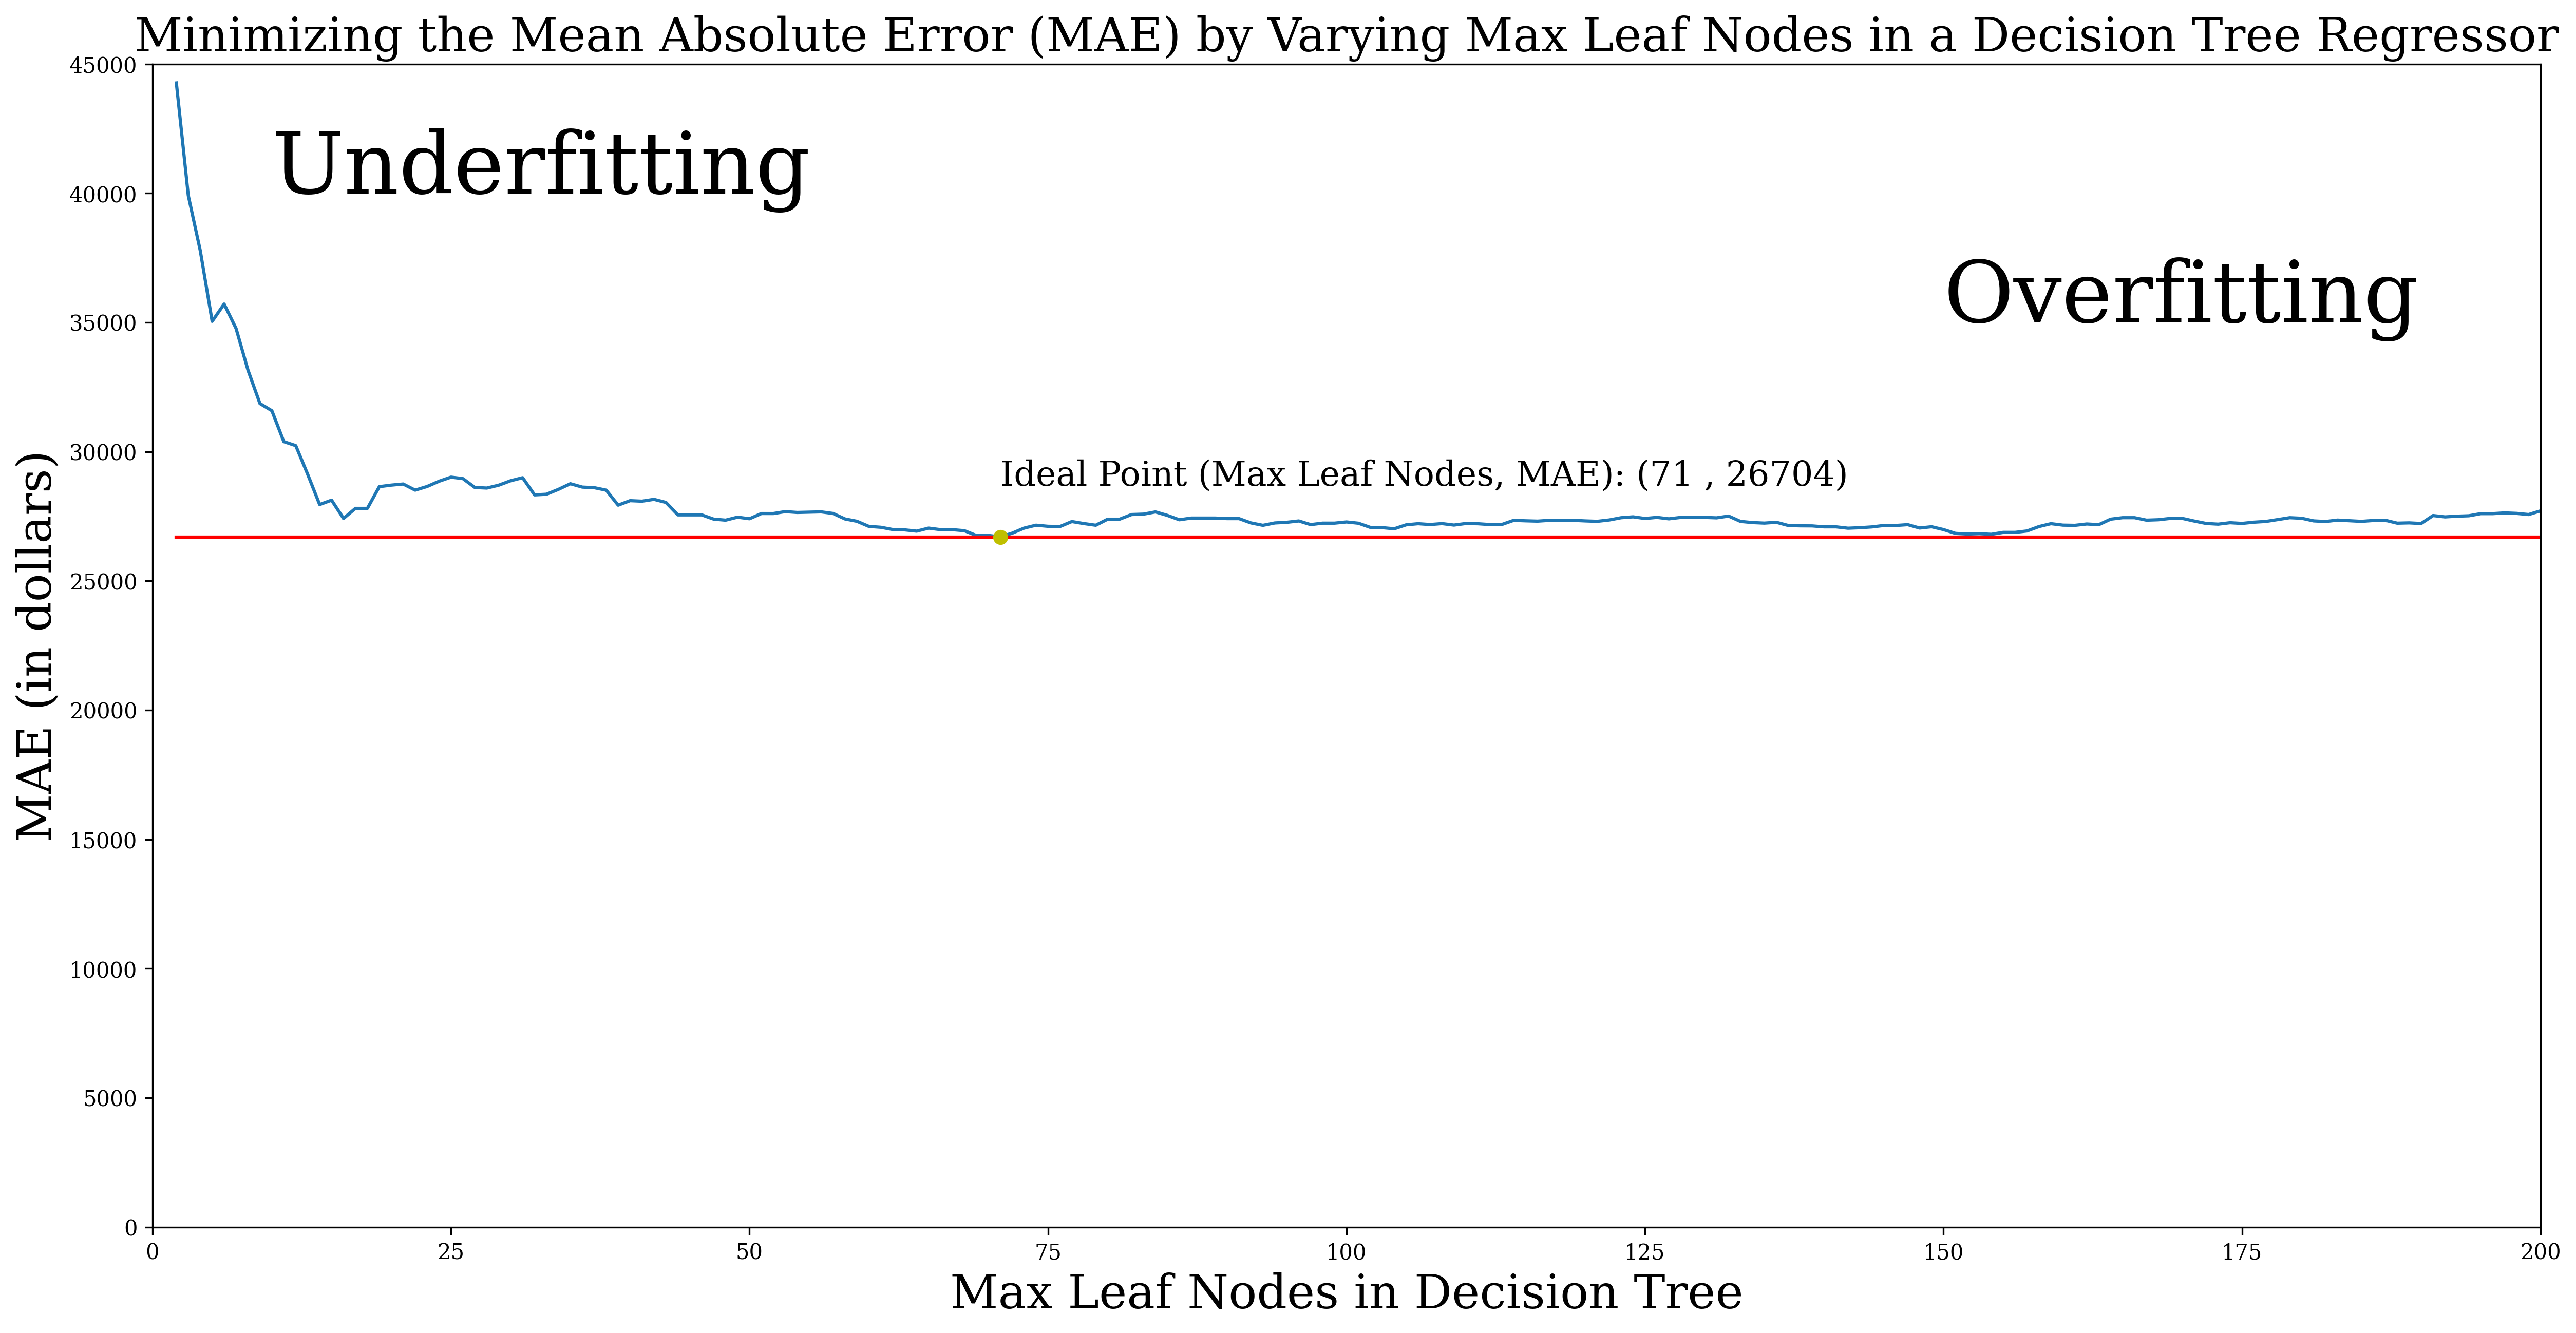

In [15]:
#Note: a special function visualize_data() was not created due to the desire for each figure to cater to visualing important ML principles highlighted in that
#figure, and therefore unique to all other figures

#Changes the image quality and font of graph
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"

#Dictates the figure size and data plotted
plt.figure(figsize=(20,10))
plt.plot(max_leaf_nodes_x_values, mae_y_values,  max_leaf_nodes_x_values, np.full((199),26704), 'r', optimal_max_leaf_node, optimal_mae, 'yo')

#Additional step needed to change the labels and title
sanserif = {'fontname':'serif'}

#Defines axis limits, y and x-axis labels, title, and places key text at meaningfull positions on the figure
plt.axis([0,200, 0,45000])
plt.ylabel(r'MAE (in dollars)', fontdict = sanserif, fontsize=22)
plt.xlabel('Max Leaf Nodes in Decision Tree', fontdict = sanserif, fontsize=22)
plt.title('Minimizing the Mean Absolute Error (MAE) by Varying Max Leaf Nodes in a Decision Tree Regressor', fontdict = sanserif, fontsize=22)
plt.text(10,40000,r'Underfitting',fontsize=40)
plt.text(150,35000,r'Overfitting',fontsize=40)
ideal_point_string = 'Ideal Point (Max Leaf Nodes, MAE): ({} , {})'.format(optimal_max_leaf_node,int(optimal_mae))
plt.text(optimal_max_leaf_node,optimal_mae+2000,ideal_point_string,fontsize=16)

#Reveals figure (think print() for matplotlib)
plt.show()

### E. Results
Note the mean absolute error over max leaf nodes presented above does not represent the prediction from the `testing_data` but rather from the `training_data` split into a training set and validation set. Here, the optimized `max_leaf_nodes` Decision Tree Regressor will be initialized, fitted on the entire `training_data` and then predict the target variable using the `testing_data`.

#### i. Predicting Sale Price with Optimized Model
The model `optimized_DT` initialized, trained with training dataset, and tested with testing dataset of predicts. The DataFrame `output` stores the `Id` of the house and `SalePrice`.

In [16]:
optimized_DT = initialize_DT(optimal_max_leaf_node)

#predictors is a group of columns defined in section "Defining Predictors"
X_testing = test_data[predictors]

predicted_y = test_model(optimized_DT, X, y, X_testing)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': predicted_y})


#### ii. Data Table of Predicted Target Variable `SalePrice`
The output represents the predicted sale prices of houses based on the predictors initialized in `X_testing`.
* For full data, click [`here`](https://github.com/rajtum/Machine-Learning-Makeshift-Portfolio/blob/master/Model%20Predictions/Predicted_Sale_Price_DT_Model.csv)

In [17]:
output.head()

,Id,SalePrice
0,1461,129504.010204
1,1462,160912.260870
2,1463,182392.319444
3,1464,182392.319444
4,1465,190290.712500


#### iii. Final Score and Interpretation 
According to the MAE, our basic optimized Decision Tree Regressor predicted housing prices in Ames, Iowa within $30,000 with the following predictors: `['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']` (information about each data field can be found [`here`](https://github.com/rajtum/Machine-Learning-Makeshift-Portfolio/blob/master/data/README.md)). The MAE values reported below, as always can be reproduced by downloading the .csv files for each model mentioned in the above section from Github and submitting them [here](https://www.kaggle.com/c/home-data-for-ml-course/submit) (you may need to a Kaggle account to submit).

In [18]:
print("MAE for Test Data: " + str(25212.19725))

MAE for Test Data: 25212.19725
